# SeaFlow data (regridded)

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'data/SeaFlow_SizeDist_regrid-15-5.nc'

data_seaflow = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_seaflow[var] = nc.variables[var][:]

In [2]:
v_min = data_seaflow['v_min']
delta_v = 1.0/data_seaflow['delta_v_inv']
v = v_min * 2**(np.arange(data_seaflow['m'])*delta_v) 

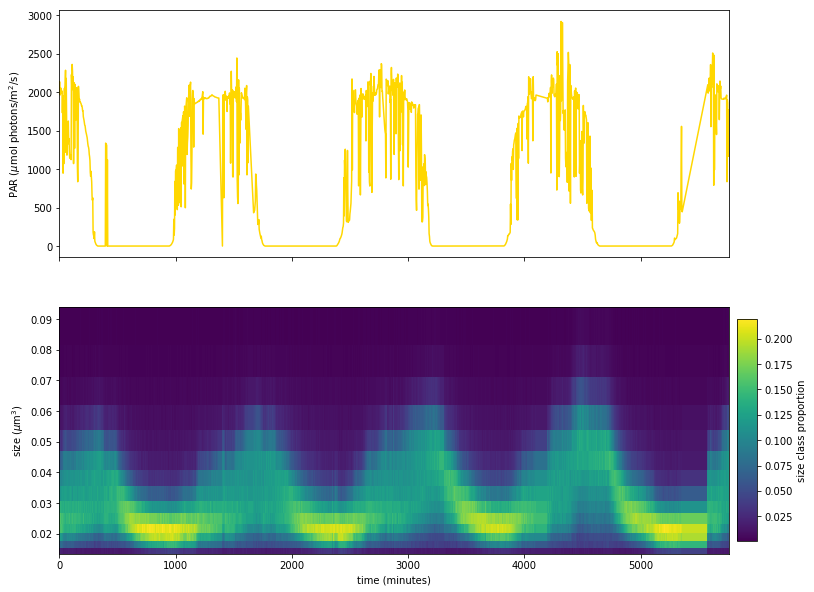

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_seaflow['time'], data_seaflow['PAR'], color='gold')
ax.set(ylabel='PAR ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
pc = ax.pcolormesh(data_seaflow['time'],v,data_seaflow['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [4]:
# prepare data for Stan model

dt = 20 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv'):
    data[k] = data_seaflow[k]

data['obs'] = data_seaflow['w_obs']
data['t_obs'] = data_seaflow['time']
data['E'] = data_seaflow['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_seaflow['w_obs'][:,0]

# limit the data

limit_days = 2
stride_t_obs = 20

# remove very first observations
ind_obs = data['t_obs'] > 3
data['t_obs'] = data['t_obs'][ind_obs]
data['obs'] = data['obs'][:,ind_obs]

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]
    
# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_seaflow['time'], fp=data_seaflow['PAR'])

In [5]:
stan_code_nomodel = '''data {
    // size variables
    int<lower=0> m;         // number of size classes
    int<lower=0> nt;        // number of timesteps
    int<lower=0> nt_obs;    // number of timesteps with observations
    // model parameters and input
    int<lower=0> dt;        // delta t in minutes
    real<lower=0> E[nt];    // vector of incident radiation values
    real<lower=0> v_min;    // size in smallest size class in um^-3
    int<lower=0> delta_v_inv;   // inverse of delta_v 
    simplex[m] w_ini;       // initial conditions 
    // observations
    real<lower=0,upper=nt*dt>  t_obs[nt_obs]; // the time of each observation
    real<lower=0> obs[m,nt_obs]; // observations
}
transformed data {
    int j;
    real<lower=0> delta_v;
    real<lower=0> dt_days;  // dt in units of days
    real<lower=0> dt_norm;  // dt in units of days and doublings
    real<lower=0> v[m];     // vector of (minimum) sizes for each size class
    int<lower=0> t[nt];     // vector of times in minutes since start 
    int<lower=1, upper=nt> it_obs[nt_obs]; // the time index of each observation

    j = 1 + delta_v_inv; 
    delta_v = 1.0/delta_v_inv;
    dt_days = dt/1440.0;
    dt_norm = dt/(1440.0 * (2^delta_v - 1.0));
    for (i in 1:m){
        v[i] = v_min*2^((i-1)*delta_v);
    }
    // populate time vector
    t[1] = 0;
    for (i in 2:nt){
        t[i] = (t[i-1] + dt);
    }
    // populate index vector it_obs
    for (k in 1:nt_obs){
        for (i in 1:nt){
            if (t_obs[k]>=t[i] && t_obs[k]<t[i]+dt){
                it_obs[k] = i;
                break;
            }
        }
    }
}
parameters {
    real<lower=0> delta_max; 
    real<lower=0> gamma_max;
    real<lower=v[1],upper=v[m]> sig_offset;
    real<lower=0> sig_steepness;
    real<lower=0, upper=5000> E_star; 
    real<lower=1e-10> sigma; 
}
transformed parameters {
    matrix[m,nt_obs] mod_obspos;
    {
        // helper variables
        vector[m] w_curr; 
        vector[m] w_next;
        real delta_i = 0.0;
        real gamma;
        real a;
        real tmp;
        int ito = 1;
        
        w_curr = w_ini;

        for (it in 1:nt){ // time-stepping loop
            // record current solution 
            if (it == it_obs[ito]){
                mod_obspos[,ito] = w_curr;
                ito += 1;
                if (ito > nt_obs){
                    break;
                }
            }
            // compute gamma
            gamma = gamma_max * dt_norm * (1.0 - exp(-E[it]/E_star));

            w_next = rep_vector(0.0, m);
            for (i in 1:m){ // size-class loop
                // compute delta_i
                if (i >= j){
                    delta_i = delta_max/(1.0+exp(-sig_steepness*(v[i]-sig_offset))) * dt_days;
                }
                
                // fill subdiagonal (growth)
                if (i < j){
                    //A[i+1,i] = gamma;
                    a = gamma;
                    w_next[i+1] += a * w_curr[i];
                } else if (i < m){
                    //A[i+1,i] = gamma * (1.0-delta_i);
                    a = gamma * (1.0-delta_i);
                    w_next[i+1] += a * w_curr[i];
                }
                // fill (j-1)th superdiagonal (division)
                if (i >= j){
                    //A[i+1-j,i] = 2.0*delta_i;
                    a = 2.0*delta_i;
                    w_next[i+1-j] += a * w_curr[i];
                }
                // fill diagonal (stasis)
                if (i < j){
                    //A[i,i] = (1.0-gamma);
                    a = (1.0-gamma);
                    w_next[i] += a * w_curr[i];
                } else if (i == m){
                    //A[i,i] = (1.0-delta_i);
                    a = (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                } else {
                    //A[i,i] = (1.0-gamma) * (1.0-delta_i);
                    a = (1.0-gamma) * (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                }
            }
            w_curr = w_next ./ sum(w_next);
        }
    }
}
'''

stan_code_model = {}

stan_code_model['old'] = '''model {
    real diff;
    
    // priors
    delta_max ~ normal(3.5, 2.0);
    sig_offset ~ uniform(v[1],v[m]);
    sig_steepness ~ lognormal(5.0,1.0);
    gamma_max ~ uniform(0.0,1440.0/dt);
    E_star ~ normal(3000.0,10.0);
    sigma ~ exponential(1000.0);

    // fitting observations
    for (it in 1:nt_obs){
        diff = 0.0;
        for (iv in 1:m){
            diff += fabs(mod_obspos[iv,it] - obs[iv,it]);
        }
        diff = diff/sigma;
        diff ~ normal(0.0, 1.0) T[0,];
    }
}
'''
stan_code_model['wide_estar'] = '''model {
    real diff;
    
    // priors
    delta_max ~ normal(3.5, 2.0);
    sig_offset ~ uniform(v[1],v[m]);
    sig_steepness ~ lognormal(5.0,1.0);
    gamma_max ~ uniform(0.0,1440.0/dt);
    E_star ~ normal(1000.0,1000.0);
    sigma ~ exponential(1000.0);

    // fitting observations
    for (it in 1:nt_obs){
        diff = 0.0;
        for (iv in 1:m){
            diff += fabs(mod_obspos[iv,it] - obs[iv,it]);
        }
        diff = diff/sigma;
        diff ~ normal(0.0, 1.0) T[0,];
    }
}
'''

In [6]:
import pystan

desc = {
    'old':'model with old "hackathon"-priors',
    'wide_estar':'model with wider prior for E_star',
}

models = {name:pystan.StanModel(model_code=stan_code_nomodel+stan_code_model[name], model_name=name, obfuscate_model_name=False) for name in stan_code_model}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL old NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL wide_estar NOW.


In [7]:
mcmc = {}
for name in models:
    mcmc[name] = models[name].sampling(data=data, iter=2000)
    print('\n'.join(x for x in mcmc[name].__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: old.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.77    0.03   0.77   2.64   3.24   3.63   4.14   5.64    814    1.0
gamma_max           4.19  8.4e-3   0.35   3.47   3.95    4.2   4.42   4.88   1761    1.0
sig_offset          0.03  8.7e-5 2.5e-3   0.03   0.03   0.03   0.04   0.04    796    1.0
sig_steepness     242.57    2.17   70.4 129.27 191.59 235.03 285.05 400.14   1053    1.0
E_star            2999.9    0.19  10.09 2979.9 2993.2 3000.2 3006.7 3018.7   2848    1.0
sigma               0.12  1.2e-4 6.2e-3    0.1   0.11   0.11   0.12   0.13   2791    1.0
lp__              -137.3    0.05   1.75 -141.4 -138.3 -137.0 -136.0 -134.8   1395    1.0

Samples were drawn using NUTS at Tue Feb  4 14:43:14 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat

Inference for Stan model: wide_estar.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           4.36    0.03   1.01   2.91   3.64   4.17   4.87   6.91   1038    1.0
gamma_max           2.29    0.02   0.69   1.61   1.85   2.02   2.51   4.23    810    1.0
sig_offset          0.04  9.7e-5 3.0e-3   0.03   0.03   0.04   0.04   0.04    955    1.0
sig_steepness     211.59    1.81  65.36 112.41 164.49 203.08 246.77 368.48   1306    1.0
E_star            819.52   29.82  825.7  38.34 178.04 466.35 1275.1 2917.1    767    1.0
sigma               0.11  1.4e-4 6.3e-3    0.1   0.11   0.11   0.12   0.13   2005    1.0
lp__              -137.4    0.05   1.76 -141.7 -138.3 -137.1 -136.1 -135.0   1232    1.0

Samples were drawn using NUTS at Tue Feb  4 14:46:16 2020.
For each parameter, n_eff is a crude measure of effective sample size,
a

## Compare parameter estimates of the two models

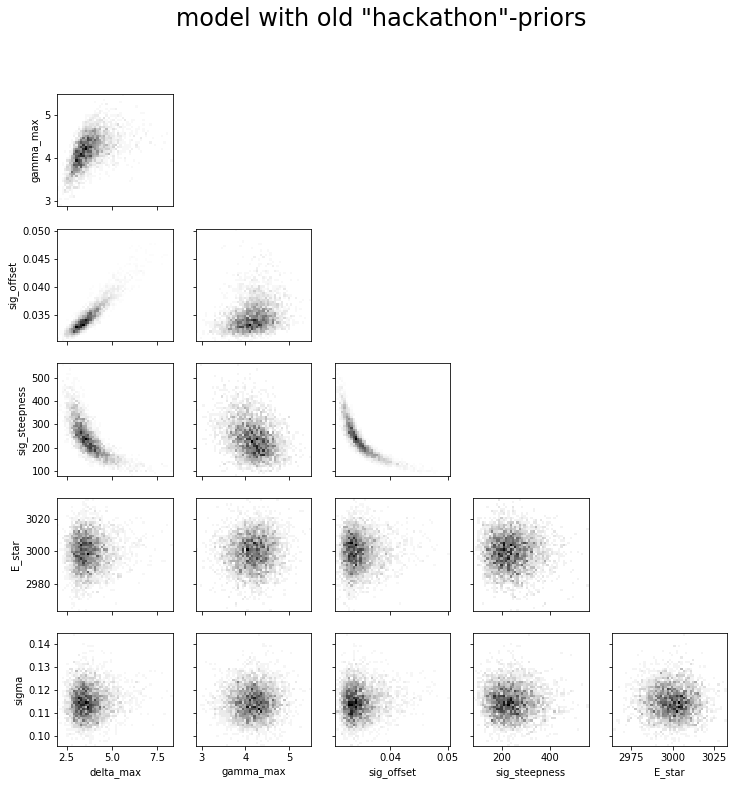

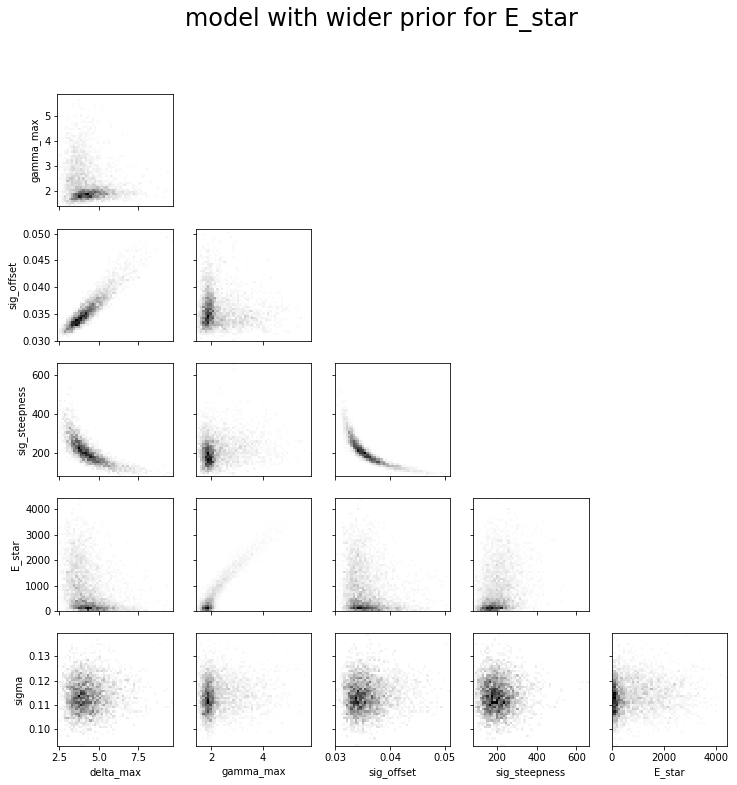

In [8]:
paramnames = [v for v in mcmc[list(models.keys())[0]].flatnames if not v.startswith('mod_obspos')]
num_params = len(paramnames)

for name in models:
    fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
    for ax in axs.flat:
        ax.set_visible(False)
    for irow in range(1,num_params):
        for icol in range(irow):
            ax = axs[irow-1,icol]
            ax.set_visible(True)
            xname = paramnames[icol]
            yname = paramnames[irow]
            ax.hist2d(mcmc[name][xname],mcmc[name][yname],bins=50,cmap=mpl.cm.gray_r)
            if icol == 0:
                ax.set_ylabel(yname)
            if irow == num_params-1:
                ax.set_xlabel(xname)
    fig.suptitle(desc[name], size=24)

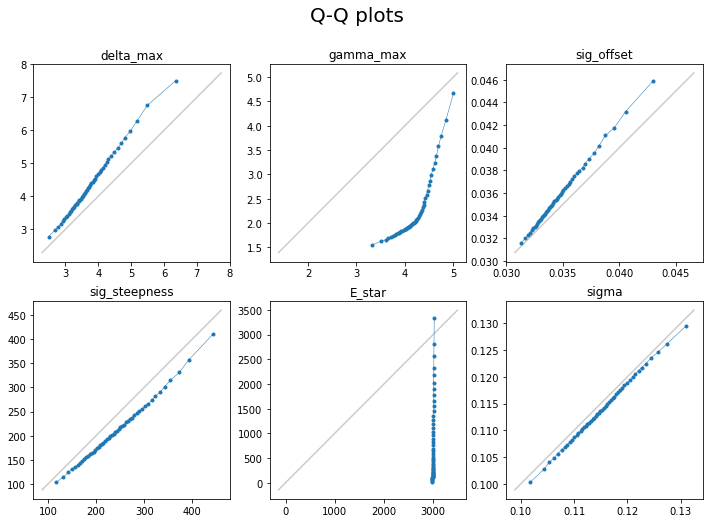

In [11]:
ncols = 3
nrows = int(np.ceil(num_params/ncols))

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,12/ncols*nrows))
for ax in axs.flat:
    ax.set_visible(False)
q = np.arange(1,100,2)
for paramname,ax in zip(paramnames,axs.flat):
    qx = np.percentile(mcmc['old'][paramname], axis=0, q=q)
    qy = np.percentile(mcmc['wide_estar'][paramname], axis=0, q=q)

    ax.set_visible(True)
    ax.plot(qx,qy,marker='.',lw=0.5)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = (min(xlim[0],ylim[0]), max(xlim[1],ylim[1]))
    ax.plot(lim,lim,color='0.8', zorder=0)
    
    ax.set(title=paramname)
fig.suptitle('Q-Q plots', size=20)
None

## Plot state estimates

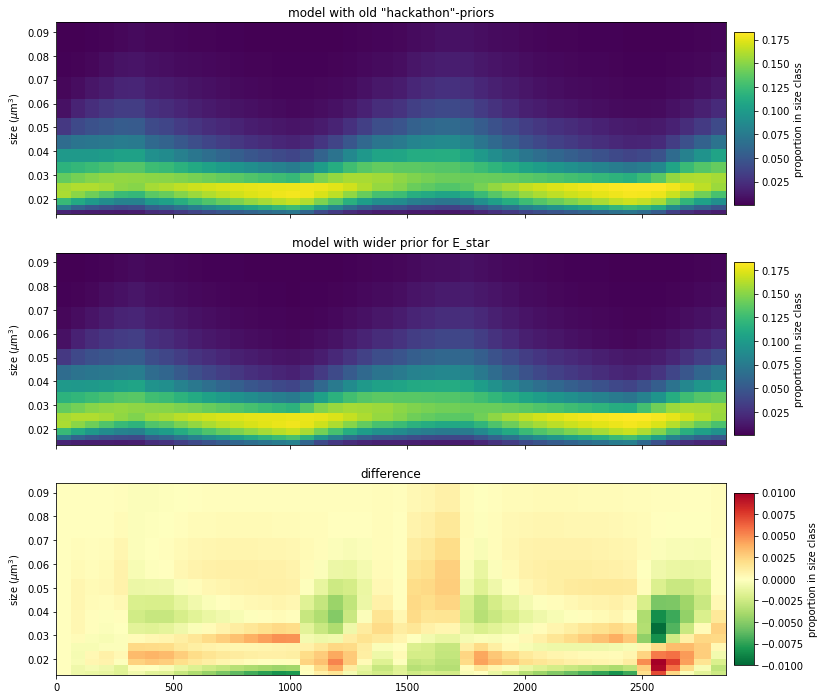

In [20]:
fig,axs = plt.subplots(nrows=3,sharex=True,figsize=(12,12))

mean = {}
for imodel,name in enumerate(models):
    mean[name] = np.mean(mcmc[name]['mod_obspos'], axis=0)
    
    ax = axs[imodel]
    pc = ax.pcolormesh(data['t_obs'],v,mean[name])
    ax.set(ylabel='size ($\mu$m$^3$)', title=desc[name])
    add_colorbar(ax, label='proportion in size class', norm=pc.norm)

ax = axs[-1]
pc = ax.pcolormesh(data['t_obs'], v, mean['old']-mean['wide_estar'], norm=mpl.colors.Normalize(vmin=-0.01, vmax=0.01), cmap=plt.get_cmap('RdYlGn_r'))
ax.set(ylabel='size ($\mu$m$^3$)', title='difference')
add_colorbar(ax, label='proportion in size class', norm=pc.norm, cmap=pc.cmap)
ax.set_xlim([0,data['t_obs'][-1]])
None